# IMPORTING LIBRARIES

In [1]:
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm as cmaps
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import re
import seaborn as sns
from scipy import stats
import random
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import boxcox
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

print("Packages loaded!")

Packages loaded!


# Pipeline Controller

df = load_original_data()
df_cleaned = delete_unncessary_columns(df)
df_cleaned = make_columns_lowercase(df_cleaned)
df_cleaned = delete_non_legit_XDC_IDs(df_cleaned)
df_cleaned, date_columns = date_columns_transform_into_datetime(df_cleaned)
df_cleaned = delete_rows_with_nan_in_selected_cols(df_cleaned, ["schmelzen_datum", "ns1_datum"])
df_cleaned = substitute_familie_int_str(df_cleaned)
df_cleaned = add_date_month_string_columns(df_cleaned, date_columns)
df_cleaned = string_comma_to_dot_float(df_cleaned)
#df_cleaned = clean_personal_names(df_cleaned)

# READ DATA INTO DATAFRAME FROM EXISTING .CSV

In [2]:
def load_original_data():
    """
    Read production data and parse into pandas dataframe.
    """
    latest_file = r"C:\Users\p.kollhof\Documents\IRONHACK_GitHub\DA_Midterm_Project\_Data\Production_Data.csv"
    df_prod_whole = pd.read_csv(latest_file, sep=";", encoding = "ISO-8859-1")
    
    return df_prod_whole

df_prod_whole = load_original_data()

# DF CLEANING

## Delete unncessary/empty colums

In [3]:
def delete_unncessary_columns(df):
    """
    Delete columns only containing NaN values or columns with effectively useless data
    """
    #try:
    cols_to_drop = []
    if any(df_prod_whole.columns.str.contains("WT1")):
        cols_to_drop_1 = [col for col in df_prod_whole.columns if "WT1" in col]
        cols_to_drop.extend(cols_to_drop_1)
    if any(df_prod_whole.columns.str.contains("WT2")):
        cols_to_drop_2 = [col for col in df_prod_whole.columns if "WT2" in col]
        cols_to_drop.extend(cols_to_drop_2)
    if any(df_prod_whole.columns.str.contains("ET2")):
        cols_to_drop_3 = [col for col in df_prod_whole.columns if "ET2" in col]
        cols_to_drop.extend(cols_to_drop_3)
    if any(df_prod_whole.columns.str.contains("FT2")):
        cols_to_drop_4 = [col for col in df_prod_whole.columns if "FT2" in col]
        cols_to_drop.extend(cols_to_drop_4)
    if any(df_prod_whole.columns.str.contains("Schneiden_Ort")):
        cols_to_drop_5 = [col for col in df_prod_whole.columns if "Schneiden_Ort" in col]
        cols_to_drop.extend(cols_to_drop_5)
    if any(df_prod_whole.columns.str.contains("Schneiden_Geraet")):
        cols_to_drop_6 = [col for col in df_prod_whole.columns if "Schneiden_Geraet" in col]
        cols_to_drop.extend(cols_to_drop_6)
    if any(df_prod_whole.columns.str.contains("Schleifen_Ort")):
        cols_to_drop_7 = [col for col in df_prod_whole.columns if "Schleifen_Ort" in col]
        cols_to_drop.extend(cols_to_drop_7)
    if any(df_prod_whole.columns.str.contains("Schleifen_Geraet")):
        cols_to_drop_8 = [col for col in df_prod_whole.columns if "Schleifen_Geraet" in col]
        cols_to_drop.extend(cols_to_drop_8)
    if any(df_prod_whole.columns.str.contains("NS2_Ort")):
        cols_to_drop_9 = [col for col in df_prod_whole.columns if "NS2_Ort" in col]
        cols_to_drop.extend(cols_to_drop_9)
    if any(df_prod_whole.columns.str.contains("OeO_Ort")):
        cols_to_drop_10 = [col for col in df_prod_whole.columns if "OeO_Ort" in col]
        cols_to_drop.extend(cols_to_drop_10)
    if any(df_prod_whole.columns.str.contains("OeO_Geraet")):
        cols_to_drop_11 = [col for col in df_prod_whole.columns if "OeO_Geraet" in col]
        cols_to_drop.extend(cols_to_drop_11)
        
    else:
        raise ValueError("Columns have already been deleted!")

    cols_to_drop.extend(["Versand_Intern", "SSMA_TimeStamp", "Assembley_Teflonschlauch-Charge"])
    df.drop(cols_to_drop, axis=1, inplace=True)

    #except:
        #raise ValueError("Deleting columns was unsuccessful!")
    
    return df

df_cleaned = delete_unncessary_columns(df_prod_whole)

## Make columns lowercase and fix syntax

In [4]:
def make_columns_lowercase(df):
    
    lower_cols = [i.lower().replace(" ", "_").replace("-", "_") for i in df.columns]
    df_cleaned.columns = lower_cols    
    
    return df_cleaned

df_cleaned = make_columns_lowercase(df_cleaned)

## Remove rows with XDC-ID < `68.000`

In [5]:
def delete_rows_with_XDC_ID_pre_68k(df):
    """
    Delete all entries before XDC-ID 68.000 due to them having wrong defect IDs.
    Only applies if dataframe actually has older entries with XDC-IDs < 68.000
    """
    
    df = df[df["pdc_nummer"]>=68000]
    
    return df

#df_cleaned = delete_rows_with_XDC_ID_pre_68k(df_cleaned)

## Remove rows with non-legit XDC-ID

In [6]:
def delete_non_legit_XDC_IDs(df):
    """
    Only keep entries with legit XDC-ID.
    Anything before 44145 is not usable.
    """
    
    df = df[df["pdc_nummer"]>=44145]
    
    return df

df_cleaned = delete_non_legit_XDC_IDs(df_cleaned)

## Cast `string-dates` into `datetime-dates`

In [7]:
def date_columns_transform_into_datetime(df):
    """
    Transform all dates of string type 'YYYY-MM-DD' into dt.datetime format.
    """
    date_cols = [col for col in df.columns if "datum" in col]

    for col in date_cols:
        if df[col].dtype == "object":
            df[col] = [dt.datetime.strptime(d,'%Y-%m-%d').date() if type(d)==str 
                       else np.nan if type(d)==float
                       else d
                       for d in df[col]]
            
    return df, date_cols

df_cleaned, date_columns = date_columns_transform_into_datetime(df_cleaned)

## Remove rows without entries in selected columns

In [8]:
def delete_rows_with_nan_in_selected_cols(df, cols):
    """
    Delete rows that do not have an entry in the given columns
    """
    for col in cols:
        df[col].dropna(inplace=True)
        df.reset_index(drop=True, inplace=True)
        
    return df
    
df_cleaned = delete_rows_with_nan_in_selected_cols(df_cleaned, ["schmelzen_datum", "ns1_datum"])

## Substitute Product-`Familie` int-values with strings *("PDC", "PDC-C", "XDC")*

In [9]:
def substitute_familie_int_str(df):
    """
    Parse int values (1,2,3) into string values ("pdc", "pdc-c", "xdc")
    """
    
    if df["familie"].dtype == "int64":
        df["familie"] = ["pdc" if fam==1
                         else "pdc-c" if fam==2
                         else "xdc" 
                         for fam in df_cleaned["familie"]]
        
    return df

df_cleaned = substitute_familie_int_str(df_cleaned)

## Create `_Months` columns

In [10]:
def add_date_month_string_columns(df, date_columns):
    """
    Convert YYYY-MM-DD dt.datetime into new 'YYYY-MM' string month column. 
    """
    
    unwanted_dates = ['ts_in_datum', 'ts_out_datum', 'rt_bqc_in_datum', 'rt_bqc_out_datum']
    date_columns_wanted = [col for col in date_columns if col not in unwanted_dates]
    date_columns_months = [col.split("_")[0] + "_month" for col in date_columns_wanted]
    #date_columns_months = [col  for col in date_columns_months]
    
    #if "schmelzen_Mmnths" in df.columns:
    for idx, datum in enumerate(date_columns_wanted):
        df[date_columns_months[idx]] = [str(d)[:-3] for d in df[datum]]
    #else:
        #raise ValueError("Months columns have already been added!")
    return df

df_cleaned = add_date_month_string_columns(df_cleaned, date_columns)

## Turn string-comma-values into dot-float-values

In [11]:
def string_comma_to_dot_float(df):
    """
    Cast string-comma-values as dot-float-values
    """
    cols_to_use = ['ns1_winkel_vorne','ns1_winkel_hinten','ns1_durchmesser_vorne','ns1_durchmesser_hinten',
               "ns2_center_variation", "ns2_front_angle","ns2_curve","ns2_15xlength",
               "ns2_parabolic_factor","oeo_oeo", "piezo_phase"] 

    for column in cols_to_use:
        df[column] = [float(str(x).replace(',','.')) for x in df[column]] 
     
    return df

df_cleaned = string_comma_to_dot_float(df_cleaned)

## Clean personal (operator) initials

In [12]:
def clean_personal_names(df):
    """
    Func descr
    """
    
    replacements = {'GD': 'GDH',
                    'MFW': 'MFE',
                    "ME": "MFE",
                    "MF": "MFE",
                    "LAE": "AL",
                    "SF": "SFZ",
                    "DC": "AC",
                    "THANH": "TT",
                    "?": np.nan}
    
    personal_cols = [col for col in df_cleaned.columns if "personal" in col]
    
    for col in personal_cols:
        op_list = []

        for op in df_cleaned["ft1_personal"]:
            if type(op)==str and op.isalpha():
                op_list.append(op.upper())
            elif op=="?":
                op_list.append(np.nan)
            elif type(op)==str and "." in op:
                op_list.append(np.nan)
            elif type(op)==str and not op.isalpha() and op!="?":
                op_list.append(op[:re.search(r'\W+', op).start()].upper())
            else:
                op_list.append(np.nan)

        op_list = [replacements.get(word, word) for word in op_list]

        df[col] = op_list
        
    return df
    
#df_cleaned = clean_personal_names(df_cleaned)

# PROCESSING `NUMERICAL` AND `CATEGORICAL` DATA

## Splitting numerical and categorical data

In [13]:
def get_numerical(df):
    
    df_edanum = df_cleaned.select_dtypes(include=np.number)

    ns1_cols = [col for col in df_edanum.columns if "ns1" in col if 'geraet' not in col]
    ns2_cols = [col for col in df_edanum.columns if "ns2" in col if 'geraet' not in col]
    piezo_cols = [col for col in df_edanum.columns if "piezo" in col]
    oeo_cols=[col for col in df_edanum.columns if "oeo" in col]
    vol_cols = [col for col in df_edanum.columns if "volume" in col]
    span_cols =[col for col in df_edanum.columns if "spannung" in col]
    pulse_col = [col for col in df_edanum.columns if "puls" in col]

    columns_to_use = ns1_cols + ns2_cols + piezo_cols + oeo_cols + span_cols + pulse_col + vol_cols

    df_numerical = df_edanum[columns_to_use]
    
    df_numerical.rename(columns={'bqc_volumen': 'qc1_volumen', 
                                 'et1_volumen': 'qc2_volumen',
                                'ft1_volumen': 'qc3_volumen',
                                'ek_volumen': 'qc4_volumen',
                                 
                                'bqc_spannung': 'qc1_spannung', 
                                 'et1_spannung': 'qc2_spannung',
                                'ft1_spannung': 'qc3_spannung',
                                'ek_spannung': 'qc4_spannung',
                                 
                                'bqc_puls': 'qc1_puls', 
                                 'et1_puls': 'qc2_puls',
                                'ft1_puls': 'qc3_puls',
                                'ek_puls': 'qc4_puls'}, inplace=True)
    
    return df_numerical

def get_categorical(df):
    df_categorical = df_cleaned.select_dtypes(include=['object'])
    
    cols_categorical = ["familie", 
                        'schmelzen_personal', "schmelzen_ort", 
                        'ns1_personal', 'schneiden_personal', 'schleifen_personal',
                        'ns2_personal', 'oeo_personal', 
                        'kleben1_personal', 'kleben2_personal',
                        'bqc_personal', 'et1_personal', 'ft1_personal', 'ek_personal']
    
    df_categorical = df_categorical[cols_categorical]
    
    df_categorical["produktion_groesse"] = df_cleaned["produktion_groesse"]
    df_categorical["art"] = df_cleaned["art"]
    df_categorical["kleben1_kleber_teilentnahme"] = df_cleaned["kleben1_kleber_teilentnahme"]
    df_categorical["kleben2_kleber_teilentnahme"] = df_cleaned["kleben2_kleber_teilentnahme"]

    return df_categorical

df_numerical = get_numerical(df_cleaned)
df_categorical = get_categorical(df_cleaned)

In [15]:
df_numerical[["ns1_winkel_vorne","ns1_winkel_hinten","ns1_durchmesser_vorne","ns1_durchmesser_hinten"]]

,ns1_winkel_vorne,ns1_winkel_hinten,ns1_durchmesser_vorne,ns1_durchmesser_hinten
0,8.00,16.00,70.10,57.40
1,9.00,15.00,70.00,60.20
2,17.00,31.00,69.90,59.60
3,5.00,43.00,68.80,60.40
4,13.00,8.00,69.60,55.40
...,...,...,...,...
112967,74.00,40.30,70.37,56.29
112968,59.50,62.40,65.70,56.71
112969,68.40,27.60,60.53,55.04
112970,50.60,41.70,69.89,57.18


## Check multicollinearity for numerical features

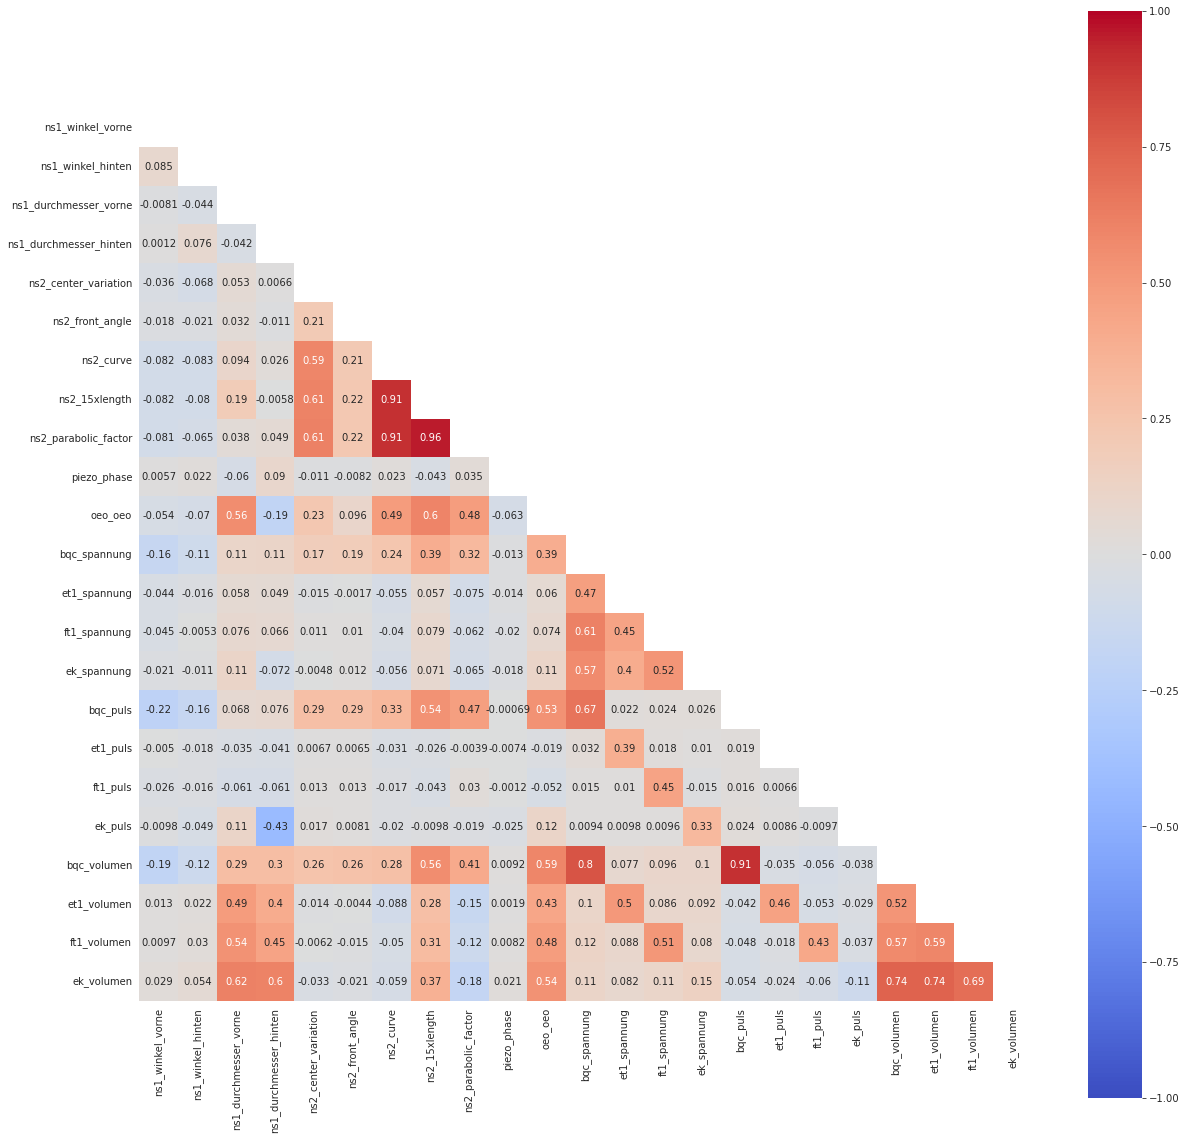

In [378]:
corr_matrix = df_numerical.corr()
corr = df_numerical.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 20))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

**`COMMENT`**
- drop either `ns2_15xlength` or `ns2_parabolic_factor`

In [379]:
def show_corr_higher_threshold(df, threshold):
    """
    Show any features that have correlation higher than threshold with any other;
    """
    corr_matrix=df.corr().abs()
    upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
    
    return [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

show_corr_higher_threshold(df_numerical, 0.8)

['ns2_15xlength', 'ns2_parabolic_factor', 'bqc_volumen']

## Processing NaN values - Numericals

In [380]:
df_numerical["piezo_phase"].mean()

73.78933726749504

### Fill NaN piezo_phase values with column mean

In [381]:
df_numerical["piezo_phase"].fillna(int(df_numerical["piezo_phase"].mean()), inplace=True)

### Fill NaN ns1 values with column mean

In [382]:
df_numerical["ns1_winkel_vorne"].fillna(np.nanmean(df_numerical["ns1_winkel_vorne"]), inplace=True)
df_numerical["ns1_winkel_hinten"].fillna(np.nanmean(df_numerical["ns1_winkel_hinten"]), inplace=True)
df_numerical["ns1_durchmesser_vorne"].fillna(np.nanmean(df_numerical["ns1_durchmesser_vorne"]), inplace=True)
df_numerical["ns1_durchmesser_hinten"].fillna(np.nanmean(df_numerical["ns1_durchmesser_hinten"]), inplace=True)

In [383]:
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112972 entries, 0 to 112971
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ns1_winkel_vorne        112972 non-null  float64
 1   ns1_winkel_hinten       112972 non-null  float64
 2   ns1_durchmesser_vorne   112972 non-null  float64
 3   ns1_durchmesser_hinten  112972 non-null  float64
 4   ns2_center_variation    112970 non-null  float64
 5   ns2_front_angle         112969 non-null  float64
 6   ns2_curve               112969 non-null  float64
 7   ns2_15xlength           112967 non-null  float64
 8   ns2_parabolic_factor    112967 non-null  float64
 9   piezo_phase             112972 non-null  float64
 10  oeo_oeo                 112948 non-null  float64
 11  bqc_spannung            35748 non-null   float64
 12  et1_spannung            22222 non-null   float64
 13  ft1_spannung            15106 non-null   float64
 14  ek_spannung         

## Processing NaN values - Categoricals

### Fill NaN values with mode in respective personal columns

In [384]:
# Get all columns containing "personal"
pers_cols = [col for col in df_categorical.columns if "personal" in col]

for col in pers_cols:
    mode = stats.mode(df_categorical[col])[0][0]
    df_categorical[col].fillna(mode, inplace=True)

### Fill missing place with P distribution, where 67% of the time the product comes from Berlin

In [385]:
df_categorical["schmelzen_ort"].fillna(random.choices(['Berlin', 'Dortmund'], 
                                                      weights=[0.67, 0.33], k=1)[0], inplace=True)

### Fill NaN values of produktion_groesse with static value 1

In [386]:
df_categorical["produktion_groesse"].fillna(1, inplace=True)

### Fill NaN kleben1_kleber_teilentnahme with average of non-zero entries
*min = 0; max = 5 --> based on procedural limits*

In [387]:
df_categorical["kleben1_kleber_teilentnahme"].fillna(int(np.mean(
    [int(k1e) for k1e in list(df_categorical["kleben1_kleber_teilentnahme"].unique()) if 6 > k1e > 0])), inplace=True)

### Fill NaN kleben2_kleber_teilentnahme with average of non-zero entries
*min = 0; max = 6 --> based on procedural limits*

In [388]:
df_categorical["kleben2_kleber_teilentnahme"].fillna(
    int(np.mean([int(k1e) for k1e in list(df_categorical["kleben2_kleber_teilentnahme"].unique()) if 7 > k1e > 0])), inplace=True)

### Fill NaN piezo_phase with average of non-zero entries

In [389]:
df_complete = pd.concat([df_numerical, df_categorical], axis=1)

df_complete_BQC = df_complete[df_complete["bqc_volumen"].notnull()].reset_index(drop=True)
df_complete_ET = df_complete[df_complete["et1_volumen"].notnull()].reset_index(drop=True)
df_complete_FT = df_complete[df_complete["ft1_volumen"].notnull()].reset_index(drop=True)
df_complete_EK = df_complete[df_complete["ek_volumen"].notnull()].reset_index(drop=True)

df_complete_BQC.drop(columns=['et1_spannung', 'ft1_spannung','ek_spannung',
                              'et1_puls', 'ft1_puls', 'ek_puls',
                     'et1_volumen', 'ft1_volumen', 'ek_volumen'], inplace=True)

In [390]:
numerical_cols_to_exclude = ['et1_spannung', 'ft1_spannung','ek_spannung',
                             'et1_puls', 'ft1_puls', 'ek_puls',
                             'et1_volumen', 'ft1_volumen', 'ek_volumen',
                            "ns2_15xlength"]
numerical_cols_to_include = [col for col in df_complete_BQC.columns if col not in numerical_cols_to_exclude]

df_complete_BQC_numerical = df_complete_BQC[numerical_cols_to_include]
df_complete_BQC_categorical = df_complete_BQC[df_categorical.columns]

## Hot-Encode categorical features

In [391]:
df_complete_BQC_categorical_hotcoded = pd.get_dummies(df_complete_BQC_categorical, drop_first=True)
df_complete_BQC_categorical_hotcoded

,produktion_groesse,art,kleben1_kleber_teilentnahme,kleben2_kleber_teilentnahme,familie_pdc-c,familie_xdc,schmelzen_personal_AH,schmelzen_personal_AK,schmelzen_personal_AL,schmelzen_personal_AL/ WH,schmelzen_personal_AL/CK,schmelzen_personal_AL/EF,schmelzen_personal_AL/FD,schmelzen_personal_AL/HG,schmelzen_personal_AL/HO,schmelzen_personal_AL/HW,schmelzen_personal_AL/PN,schmelzen_personal_AL/WH,schmelzen_personal_BP,schmelzen_personal_BP / PK,schmelzen_personal_BP/ PK,schmelzen_personal_BP/EL,schmelzen_personal_BP/PK,schmelzen_personal_CF,schmelzen_personal_CK,schmelzen_personal_CK / WH,schmelzen_personal_CK/AL,schmelzen_personal_CK/FD,schmelzen_personal_CK/HO,schmelzen_personal_CK/WH,schmelzen_personal_CT,schmelzen_personal_ChT,schmelzen_personal_Ck,schmelzen_personal_EC,schmelzen_personal_EF,schmelzen_personal_EF/AL,schmelzen_personal_EF/BS,schmelzen_personal_EF/CK,schmelzen_personal_EF/HG,schmelzen_personal_EF/HO,schmelzen_personal_EF/PN,schmelzen_personal_EF/WH,schmelzen_personal_EL,schmelzen_personal_EL/BA,schmelzen_personal_EL/BP,schmelzen_personal_El,schmelzen_personal_FD,schmelzen_personal_FD/AL,schmelzen_personal_FD/EF,schmelzen_personal_FD/WH,schmelzen_personal_FT,schmelzen_personal_GM,schmelzen_personal_GM/PN/HO,schmelzen_personal_HD,schmelzen_personal_HG,schmelzen_personal_HG/AL,schmelzen_personal_HG/EF,schmelzen_personal_HO,schmelzen_personal_HO/AL,schmelzen_personal_HO/CK,schmelzen_personal_HO/EF,schmelzen_personal_HO/FD,schmelzen_personal_HO/PN,schmelzen_personal_HO/WH,schmelzen_personal_JAB,schmelzen_personal_JW,schmelzen_personal_NK,schmelzen_personal_PE,schmelzen_personal_PE/AL,schmelzen_personal_PK,schmelzen_personal_PK/BP,schmelzen_personal_PK/SS,schmelzen_personal_PN,schmelzen_personal_PN/AL,schmelzen_personal_PN/EF,schmelzen_personal_PN/HO,schmelzen_personal_PN/WH,schmelzen_personal_RAP,schmelzen_personal_RB,schmelzen_personal_RP,schmelzen_personal_RT,schmelzen_personal_Rap,schmelzen_personal_SM,schmelzen_personal_SO,schmelzen_personal_SO/PN,schmelzen_personal_SS,schmelzen_personal_SS/PK,schmelzen_personal_So,schmelzen_personal_THANH,schmelzen_personal_TM,schmelzen_personal_TT,schmelzen_personal_UB,schmelzen_personal_UB/PN,schmelzen_personal_WH,schmelzen_personal_WH / AL,schmelzen_personal_WH / FD,schmelzen_personal_WH/AL,schmelzen_personal_WH/CK,schmelzen_personal_WH/EF,schmelzen_personal_WH/FD,schmelzen_personal_WH/HG,schmelzen_personal_WH/HO,schmelzen_personal_WH/PN,schmelzen_personal_WO,schmelzen_ort_Berlin,schmelzen_ort_Dortmund,schmelzen_ort_berlin,ns1_personal_AH,ns1_personal_AH/EL/RP,ns1_personal_AK,ns1_personal_AK/RP,ns1_personal_AL,ns1_personal_AL/DM,ns1_personal_AL/HO,ns1_personal_AL/PN,ns1_personal_BP,ns1_personal_CHT,ns1_personal_CK,ns1_personal_CT,ns1_personal_CT/EL,ns1_personal_ChT,ns1_personal_DM,ns1_personal_DM/AL,ns1_personal_DM/GM,ns1_personal_DM/PN,ns1_personal_EC,ns1_personal_EC/BP,ns1_personal_EC/CT,ns1_personal_EF,ns1_personal_EL,ns1_personal_EL/RP,ns1_personal_EL/TM,ns1_personal_FD,ns1_personal_FD/AL,ns1_personal_FT,ns1_personal_GM,ns1_personal_HD,ns1_personal_HG,ns1_personal_HO,ns1_personal_HO/AL,ns1_personal_HO/DM,ns1_personal_HO/FD,ns1_personal_HO/GM,ns1_personal_HO/PN,ns1_personal_JAB,ns1_personal_MT,ns1_personal_NK,ns1_personal_PE,ns1_personal_PK,ns1_personal_PN,ns1_personal_PN/DM,ns1_personal_RAP,ns1_personal_RP,ns1_personal_RP/AL,ns1_personal_RP/CT,ns1_personal_Rap,ns1_personal_SM,ns1_personal_SM/AL,ns1_personal_TT,schneiden_personal_AH,schneiden_personal_AK,schneiden_personal_AL,schneiden_personal_AL/CK,schneiden_personal_BP,schneiden_personal_BS,schneiden_personal_CK,schneiden_personal_CK/DM,schneiden_personal_CT,schneiden_personal_CT/EL,schneiden_personal_ChT,schneiden_personal_DM,schneiden_personal_EC,schneiden_personal_EC/AK,schneiden_personal_EC/CT,schneiden_personal_EF,schneiden_personal_EF/AL,schneiden_personal_EF/HO,schneiden_personal_EL,schneiden_personal_FD,schneiden_personal_FT,schneiden_personal_GM,schneiden_personal_GM/DM,schneiden_personal_GM/EF,schneiden_pers

# Linear Regression

In [393]:
df_numerical.drop(columns=['et1_spannung', 'ft1_spannung','ek_spannung',
                              'et1_puls', 'ft1_puls', 'ek_puls',
                     'et1_volumen', 'ft1_volumen', 'ek_volumen'], inplace=True)

df_numerical = df_numerical[df_numerical["bqc_volumen"]>0].reset_index(drop=True)

df_numerical.dropna(axis=0, inplace=True)

In [394]:
df_numerical_complete_BQC_categorical = pd.concat((df_complete_BQC_categorical_hotcoded, df_numerical), axis=1)
df_numerical_complete_BQC_categorical.dropna(axis=0, inplace=True)

## X-y Split (`y` is the target variable, which is the `total claim amount`)

In [395]:
#df_to_use = df_numerical_complete_BQC_categorical
df_to_use = df_numerical

In [396]:
X = df_to_use.drop('bqc_volumen', axis=1)
y = df_to_use["bqc_volumen"]

## Train - Test - Split

In [397]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3,random_state=6969)

## Standardize the data after data split

In [398]:
# Standardize training data
std_scaler = StandardScaler().fit(X_train) # get mean, variance from training set

# Scale training data
X_train_scaled = std_scaler.transform(X_train)

# Scale test data with mean, variance from training data
X_test_scaled = std_scaler.transform(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)

model=LinearRegression()             # model
model.fit(X_train_scaled, y_train)   # model train

print("Coefficients: ", model.coef_)
print("Coefficients: ", model.intercept_)

y_pred=model.predict(X_test_scaled)   # model prediction
y_pred_train=model.predict(X_train_scaled)

(21289, 13) (9125, 13)
Coefficients:  [ 0.65761441  1.05049278 37.585694   -0.1024676  -0.94211269  0.24288013
 -7.34696885  0.93111482 -8.36331012  0.7380673   9.70139359  2.19916605
  4.0485869 ]
Coefficients:  373.9557987693174


## Evaluating Model Performance

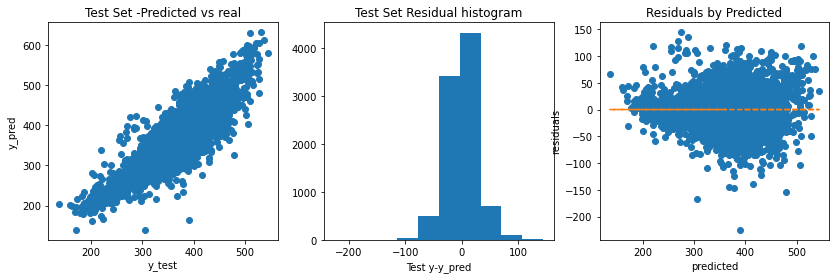

In [399]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

# Homoscdasticity
# Check if residuals are somewhat uniformally distributed around null-line
ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')
plt.show()

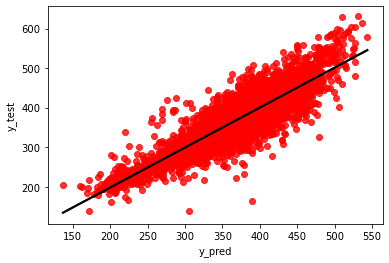

In [400]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})
plt.show()

## Error metrics

In [401]:
mse_1 = round(mse(y_test,y_pred),2)
rmse_1 = round(np.sqrt(mse(y_test,y_pred)),2)
mae_1 = round(mae(y_test,y_pred),2)

print("MSE:", mse_1) # shows squared error (harder to interpret)
print("MAE:", mae_1) # shows real error (in $)
print("-----")

# R^2
R2_1 = round(r2_score(y_test,y_pred),2)

# Adj. R^2
Adj_R2_1 = round(1 - (1-R2_1)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),2) # X_test.shape[1] == len(X_test.columns)

print(f"R^2 for <numerical (with outliers) only> is {round(R2_1,2)}.")
print(f"Adjusted R^2 for <numerical (with outliers) only> is {round(Adj_R2_1,2)}.")

MSE: 746.93
MAE: 20.35
-----
R^2 for <numerical (with outliers) only> is 0.76.
Adjusted R^2 for <numerical (with outliers) only> is 0.76.


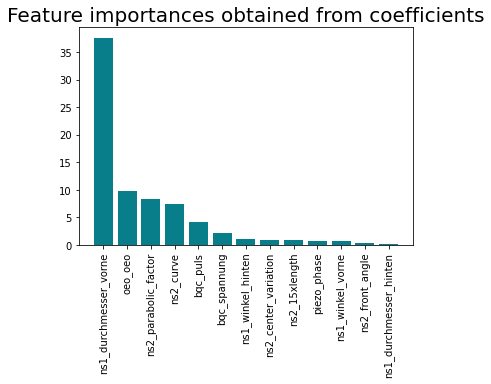

In [402]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)})

features_importances = features_importances.sort_values(by='Importance', ascending=False)

plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()